In [1]:
import sys; sys.path.append('..')
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import jittor as jt
from model_jittor.ldm.ddpm import LatentDiffusion

jt.flags.use_cuda=True

%load_ext autoreload
%autoreload 2

[i 0708 07:17:26.930062 64 log.cc:351] Load log_sync: 1
[i 0708 07:17:27.036881 64 compiler.py:953] Jittor(1.3.4.15) src: /root/miniconda3/envs/jittor/lib/python3.7/site-packages/jittor
[i 0708 07:17:27.047706 64 compiler.py:954] g++ at /usr/bin/g++(7.5.0)
[i 0708 07:17:27.049552 64 compiler.py:955] cache_path: /root/.cache/jittor/jt1.3.4/g++7.5.0/py3.7.0/Linux-4.4.0-11x84/IntelRXeonRGolxda/default
[i 0708 07:17:27.060714 64 __init__.py:411] Found /usr/local/cuda/bin/nvcc(11.2.152) at /usr/local/cuda/bin/nvcc.
[i 0708 07:17:27.071972 64 __init__.py:411] Found addr2line(2.30) at /usr/bin/addr2line.
[i 0708 07:17:27.259798 64 compiler.py:1008] cuda key:cu11.2.152_sm_75
[i 0708 07:17:27.582402 64 __init__.py:227] Total mem: 376.57GB, using 16 procs for compiling.
[i 0708 07:17:27.796118 64 jit_compiler.cc:28] Load cc_path: /usr/bin/g++
[i 0708 07:17:28.105583 64 init.cc:62] Found cuda archs: [75,]
[i 0708 07:17:28.887549 64 __init__.py:411] Found mpicc(2.1.1) at /usr/bin/mpicc.
[i 0708 07

: 

[i 0708 01:11:00.679470 08 cuda_flags.cc:32] CUDA enabled.


In [28]:
config = OmegaConf.load('../configs/ldm_simplified.yaml')
model = LatentDiffusion(**config.model)

Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
Spatial Rescaler mapping from 29 to 3 channels after resizing.


In [29]:
import torch
unet_ckpt = torch.load('/nas/ckpts/unet.ckpt')
model.model.load_state_dict(unet_ckpt)

vq_ckpt = torch.load('/nas/ckpts/unet.ckpt')
model.first_stage_model.load_state_dict(vq_ckpt)

rescaler_ckpt = torch.load('/nas/ckpts/unet.ckpt')
model.cond_stage_model.load_state_dict(rescaler_ckpt)

In [30]:

from PIL import Image
import os
import numpy as np
import jittor.transform as transforms

name1 = '3477113127_aca40d90bb_b.jpg'
name2 = '16509884617_9aef0a5dd3_b.jpg'
SEG_PATH = '/nas/landscape/train_val/labels'
IMG_PATH = '/nas/landscape/train_val/images'
seg1 = Image.open(os.path.join(SEG_PATH, name1.replace('.jpg', '.png')))
img1 = Image.open(os.path.join(IMG_PATH, name1))
seg2 = Image.open(os.path.join(SEG_PATH, name2.replace('.jpg', '.png')))
img2 = Image.open(os.path.join(IMG_PATH, name2))
seg1 = np.array(seg1)
seg2 = np.array(seg2)
img1 = np.array(img1)
img2 = np.array(img2)
trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 512)),
    transforms.ToTensor(),    # A.RandomCrop(256, 256),
])

img1 = trans(img1)  # np.ndarray
seg1 = trans(seg1)
img2 = trans(img2)
seg2 = trans(seg2)

img1 = img1[np.newaxis]
img2 = img2[np.newaxis]

seg1 = jt.init.eye(29)[jt.array(seg1)].permute(0, 3, 1, 2).float()
seg2 = jt.init.eye(29)[jt.array(seg2)].permute(0, 3, 1, 2).float()

In [31]:
print(img1.shape, seg1.shape)
seg_batch = jt.concat([seg1, seg2], dim=0)
print(seg_batch.shape)

(1, 3, 384, 512) [1,29,384,512,]
[2,29,384,512,]


In [32]:
img, inter = model.sample(seg_batch, return_intermediates=True)

Sampling t: 100%|██████████| 1000/1000 [01:28<00:00, 11.24it/s]


In [33]:
img.shape

[2,3,96,128,]

In [34]:
img_dec = model.decode_first_stage(img)
print(img_dec.shape)

[2,3,384,512,]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


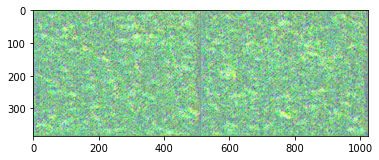

In [35]:
from utils import make_grid
grid = make_grid(img_dec.data, 2)
plt.imshow((grid + 1) / 2)

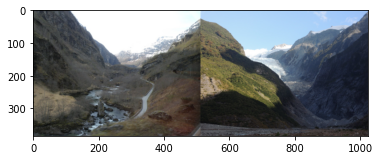

In [36]:
grid = make_grid(jt.concat((img1, img2), dim=0).data, 2)
plt.imshow(grid)

In [38]:
# img_recon = img_dec.data

# print(img_recon.max())
# print(img_recon.min())
# print(img_recon[0, 0, :10, :10])


# 3.1189582
# -1.776812
# [[-0.0134224  -0.04665706 -0.007147    0.08256257  0.12023848  0.10760016
#    0.06348368  0.09534314  0.11582314  0.0286438 ]
#  [-0.05955317 -0.08087904  0.00928458  0.1704065   0.25532106  0.25026682
#    0.0757646  -0.08205672 -0.00455548 -0.18735468]
#  [-0.0053499  -0.06626508 -0.01576312  0.10132489  0.11578524  0.03629289
#    0.07071991 -0.05185221  0.10500024 -0.06015508]
#  [-0.04148031 -0.10982612 -0.02226525  0.09757515  0.18560769  0.319817
#    0.24386021 -0.08649703  0.04440184 -0.09833711]
#  [ 0.09112153 -0.02595183  0.08149606  0.11404113  0.21399553  0.181297
#    0.05836348 -0.2284557   0.07218937  0.01653255]
#  [ 0.02914749 -0.02419472 -0.11269405 -0.14935446  0.05495018  0.01924326
#   -0.00126598 -0.00314926  0.17927371  0.07675431]
#  [ 0.04092492  0.01984936  0.03831716 -0.07441432  0.15641356  0.14016832
#    0.19856735  0.38822156  0.33468536  0.20515959]
#  [-0.10667188 -0.17021514 -0.07255768 -0.25026253  0.00544394 -0.01387576
#   -0.02651695  0.12399915  0.15123828  0.04107497]
#  [-0.15357774 -0.14704837 -0.06879265 -0.1575359  -0.06773823  0.01458174
#    0.07319891  0.2842966   0.23926504  0.09186988]
#  [-0.26574686 -0.20399825 -0.08010738 -0.06436954  0.02461679  0.18736638
#    0.06474397  0.13150433  0.06091116  0.0187841 ]]

3.1189582
-1.776812
[[-0.0134224  -0.04665706 -0.007147    0.08256257  0.12023848  0.10760016
   0.06348368  0.09534314  0.11582314  0.0286438 ]
 [-0.05955317 -0.08087904  0.00928458  0.1704065   0.25532106  0.25026682
   0.0757646  -0.08205672 -0.00455548 -0.18735468]
 [-0.0053499  -0.06626508 -0.01576312  0.10132489  0.11578524  0.03629289
   0.07071991 -0.05185221  0.10500024 -0.06015508]
 [-0.04148031 -0.10982612 -0.02226525  0.09757515  0.18560769  0.319817
   0.24386021 -0.08649703  0.04440184 -0.09833711]
 [ 0.09112153 -0.02595183  0.08149606  0.11404113  0.21399553  0.181297
   0.05836348 -0.2284557   0.07218937  0.01653255]
 [ 0.02914749 -0.02419472 -0.11269405 -0.14935446  0.05495018  0.01924326
  -0.00126598 -0.00314926  0.17927371  0.07675431]
 [ 0.04092492  0.01984936  0.03831716 -0.07441432  0.15641356  0.14016832
   0.19856735  0.38822156  0.33468536  0.20515959]
 [-0.10667188 -0.17021514 -0.07255768 -0.25026253  0.00544394 -0.01387576
  -0.02651695  0.12399915  0.151238